# Train a JointVAE model

### Get MNIST data
Build a simple JointVAE model on MNIST

In [1]:
VAE_TRAIN = False

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [42]:
from dataloaders import get_mnist_dataloaders_attack, get_mnist_dataloaders
# train_loader, test_loader = get_mnist_dataloaders_attack(2, 5, train_batch_size=64, test_batch_size=64, path_to_data='/home/data/bvaa')
train_loader, test_loader = get_mnist_dataloaders(batch_size=64, path_to_data='/home/data/bvaa')

In [20]:
from torchvision import datasets, transforms
all_transforms = transforms.Compose([
        transforms.Resize(32),
        transforms.ToTensor()
    ])
train_data = datasets.MNIST('/home/data/bvaa/', train=True, download=True,
                                transform=all_transforms)

### Define latent distribution of the model

In [4]:
# Latent distribution will be joint distribution of 10 gaussian normal distributions
# and one 10 dimensional Gumbel Softmax distribution
latent_spec = {'cont': 10,
               'disc': [10]}

### Build a model

In [5]:
from models import VAE

model = VAE(latent_spec=latent_spec, img_size=(1, 32, 32), use_cuda=True).cuda()

### Train the model

In [6]:
from torch import optim

# Build optimizer
optimizer = optim.Adam(model.parameters(), lr=5e-4)

In [7]:

class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.softmax(x, dim=1)
        return output

classifier = Classifier().cuda()
classifier.load_state_dict(torch.load('../VAE/models/mnist_cnn_non_log.pt'))

<All keys matched successfully>

In [8]:
from training import Trainer

# Define the capacities
# Continuous channels
cont_capacity = [0.0, 5.0, 25000, 30.0]  # Starting at a capacity of 0.0, increase this to 5.0
                                         # over 25000 iterations with a gamma of 30.0
# Discrete channels
disc_capacity = [0.0, 5.0, 25000, 30.0]  # Starting at a capacity of 0.0, increase this to 5.0
                                         # over 25000 iterations with a gamma of 30.0

# Build a trainer
trainer = Trainer(model, optimizer,
                  cont_capacity=cont_capacity,
                  disc_capacity=disc_capacity, use_cuda=True)

In [9]:
# # Build a visualizer which will be passed to trainer to visualize progress during training
# from visualize import Visualizer

# viz = Visualizer(model)

In [10]:
# Train model for 10 epochs
# Note this should really be a 100 epochs and trained on a GPU, but this is just to demo

# trainer.train(train_loader, epochs=100, save_training_gif=('./training.gif', viz))
if VAE_TRAIN:
    trainer.train(train_loader, epochs=100)
    torch.save(model.state_dict(), 'models/vae.pth')
else:
    model.load_state_dict(torch.load('models/vae.pth'))
    model.eval()

## Attack

In [11]:
attack_digit = 2
target_digit = 5

In [12]:
# torch.where(example_targets==1)[0].tolist()

### Visualize

In [45]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

In [46]:
example_data.shape

torch.Size([64, 1, 32, 32])

In [13]:
def plot_64(data):
    l_sample = None
    for i in range(data.shape[0]):
        output, l_dist_x = model(data[i,:,:,:].unsqueeze(0).cuda())
        l_sample_x = model.reparameterize(l_dist_x)
        if l_sample is None:
            l_sample = l_sample_x
        else:
            l_sample += l_sample_x
    l_sample = l_sample / data.shape[0]
    new_output = model.decode(l_sample)
    plt.imshow(new_output[0][0].detach().cpu().numpy(), cmap='gray', interpolation='none')
    pred = classifier(F.upsample(new_output, (28,28), mode='bilinear', align_corners=True))
    print(pred)
    print(torch.argmax(pred))
    return l_sample

In [14]:
def get_batch_avg(data):
    l_sample = None
    for i in range(data.shape[0]):
        output, l_dist_x = model(data[i,:,:,:].unsqueeze(0).cuda())
        l_sample_x = model.reparameterize(l_dist_x)
        if l_sample is None:
            l_sample = l_sample_x
        else:
            l_sample += l_sample_x
    l_sample = l_sample / data.shape[0]
#     new_output = model.decode(l_sample)
#     plt.imshow(new_output[0][0].detach().cpu().numpy(), cmap='gray', interpolation='none')
#     pred = classifier(F.upsample(new_output, (28,28), mode='bilinear', align_corners=True))
#     print(pred)
#     print(torch.argmax(pred))
    return l_sample

In [15]:
def plot_avg_mnist(img1, data):
#     new_l_sample = None
#     count = len(list_to_process)
    output, l_dist_x = model(img1.cuda())
    l_sample_x = model.reparameterize(l_dist_x)
    l_sample_y = get_batch_avg(data)
#     output, l_dist_y = model(img2.cuda())
#     l_sample_y = model.reparameterize(l_dist_y)
    
    l_sample = 1*l_sample_x + 0.4*l_sample_y
    
    new_output = model.decode(l_sample)
#     for i in list_to_process:
#         example_img = example_data[i,:,:,:].unsqueeze(0).cuda()
#         output, l_dist = model(example_img)
#         l_sample = model.reparameterize(l_dist)
#         if new_l_sample is None:
#             new_l_sample = l_sample
#         else:
#             new_l_sample += l_sample
#     new_l_sample = new_l_sample / count
#     new_output = model.decode(new_l_sample)
    plt.imshow(new_output[0][0].detach().cpu().numpy(), cmap='gray', interpolation='none')
    pred = classifier(F.upsample(new_output, (28,28), mode='bilinear', align_corners=True))
    print(pred)
    print(torch.argmax(pred))
    print(pred[0,2].item(), pred[0,5].item())

In [16]:
plot_avg_mnist(example_data[0][3].unsqueeze(0), example_data[1])

IndexError: too many indices for tensor of dimension 1

tensor([[9.7418e-04, 5.3215e-05, 1.9554e-06, 1.1177e-03, 1.6990e-04, 9.8696e-01,
         1.1214e-04, 3.0288e-05, 1.3978e-03, 9.1855e-03]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor(5, device='cuda:0')


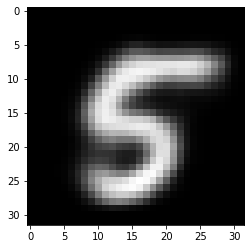

In [78]:
plot_64(example_data[1])

In [16]:
example_img = example_data[12,:,:,:].unsqueeze(0).cuda()
output, l_dist = model(example_img)

In [17]:
l_sample = model.reparameterize(l_dist)

In [18]:
# new_l_sample = l_sample
new_l_sample = 0.9 * l_sample
new_output = model.decode(new_l_sample)

In [19]:
cos = nn.CosineSimilarity(dim=1, eps=1e-6)
output_sim = cos(l_sample, new_l_sample)
print(output_sim)

tensor([1.], device='cuda:0', grad_fn=<DivBackward0>)


In [23]:
def plot_mnist(list_to_process):
    new_l_sample = None
    count = len(list_to_process)
    for i in list_to_process:
        example_img = example_data[i,:,:,:].unsqueeze(0).cuda()
        output, l_dist = model(example_img)
        l_sample = model.reparameterize(l_dist)
        if new_l_sample is None:
            new_l_sample = l_sample
        else:
            new_l_sample += l_sample
    new_l_sample = new_l_sample / count
    new_output = model.decode(new_l_sample)
    plt.imshow(new_output[0][0].detach().cpu().numpy(), cmap='gray', interpolation='none')

In [29]:
def check(i, j, alpha, beta):
    im1 = example_data[i,:,:,:].unsqueeze(0).cuda()
    im2 = example_data[j,:,:,:].unsqueeze(0).cuda()
    out1, l_dist1 = model(im1)
    out2, l_dist2 = model(im2)
    l_sample1 = model.reparameterize(l_dist1)
    l_sample2 = model.reparameterize(l_dist2)
    l_sample = alpha*l_sample1 + beta*l_sample2
    new_out = model.decode(l_sample)
#     new_out1 = model.decode(l_sample1)
#     new_out2 = model.decode(l_sample2)
    plt.figure(figsize=(10,15))
    plt.subplot(1,3,1)
    plt.imshow(example_data[i][0].detach().cpu().numpy(), cmap='gray', interpolation='none')
    plt.subplot(1,3,2)
    plt.imshow(example_data[j][0].detach().cpu().numpy(), cmap='gray', interpolation='none')
    plt.subplot(1,3,3)
    plt.imshow(new_out[0][0].detach().cpu().numpy(), cmap='gray', interpolation='none')
    print(torch.argmax(classifier(F.upsample(new_out, (28,28), mode='bilinear', align_corners=True))))

tensor(2, device='cuda:0')


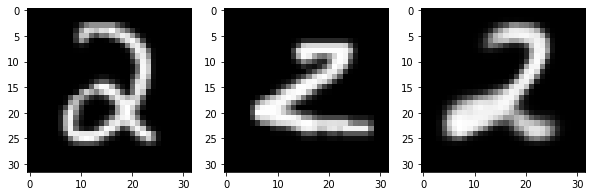

In [30]:
alpha=1
beta = 1.2
check(19,11, alpha, beta)

In [12]:
# class Attack(nn.Module):
#     def __init__(self, attack_digit=attack_digit, target_digit=target_digit, vae=model, classifier=classifier, avg_latent=l_sample_list):
#         super(self, Attack).__init__()
#         self.classifier = classifier
#         self.classifier.eval()
#         self.vae = vae
#         self.vae.eval()
#         self.avg_latent = avg_latent
#         self.attack_digit = attack_digit
#         self.target_digit = target_digit
#         self.hidden_layers = hidden_layers
#         self.hidden_layers.insert(0, latent_dim)
#         self.hidden_layers.append(latent_dim)
#         self.layers = []
        
#         for i in range(len(self.hidden_layers)-1):
#             self.layers.append(nn.Linear(self.hidden_layers[i], self.hidden_layers[i+1]))
        
#         self.layers = nn.ModuleList(self.layers)
        
#     def forward(self, x, y):
#         _, l_dist_x = self.vae(x)
#         _, l_dist_y = self.vae(y)
#         l_sample_x = self.vae.reparameterize(l_dist_x)
#         l_sample_y = self.vae.reparameterize(l_dist_y)
#         noised_sample = l_sample
#         for layer in self.layers:
#             noised_sample = layer(noised_sample)
#         noised_images = self.vae.decoder(noised_sample)
#         preds = self.classifier(F.upsample(noised_image, (28,28), mode='bilinear', align_corners=True))
#         return x

In [17]:
from math import exp

def gaussian(window_size, sigma):
    gauss = torch.Tensor([exp(-(x - window_size//2)**2/float(2*sigma**2)) for x in range(window_size)])
    return gauss/gauss.sum()

def create_window(window_size, channel):
    _1D_window = gaussian(window_size, 1.5).unsqueeze(1)
    _2D_window = _1D_window.mm(_1D_window.t()).float().unsqueeze(0).unsqueeze(0)
    window = torch.Tensor(_2D_window.expand(channel, 1, window_size, window_size).contiguous())
    return window

def _ssim(img1, img2, window, window_size, channel, size_average = True):
    mu1 = F.conv2d(img1, window, padding = window_size//2, groups = channel)
    mu2 = F.conv2d(img2, window, padding = window_size//2, groups = channel)

    mu1_sq = mu1.pow(2)
    mu2_sq = mu2.pow(2)
    mu1_mu2 = mu1*mu2

    sigma1_sq = F.conv2d(img1*img1, window, padding = window_size//2, groups = channel) - mu1_sq
    sigma2_sq = F.conv2d(img2*img2, window, padding = window_size//2, groups = channel) - mu2_sq
    sigma12 = F.conv2d(img1*img2, window, padding = window_size//2, groups = channel) - mu1_mu2

    C1 = 0.01**2
    C2 = 0.03**2

    ssim_map = ((2*mu1_mu2 + C1)*(2*sigma12 + C2))/((mu1_sq + mu2_sq + C1)*(sigma1_sq + sigma2_sq + C2))

    if size_average:
        return ssim_map.mean()
    else:
        return ssim_map.mean(1).mean(1).mean(1)

class SSIM(nn.Module):
    def __init__(self, window_size = 11, size_average = True):
        super(SSIM, self).__init__()
        self.window_size = window_size
        self.size_average = size_average
        self.channel = 1
        self.window = create_window(window_size, self.channel)

    def forward(self, img1, img2):
        (_, channel, _, _) = img1.size()

        if channel == self.channel and self.window.data.type() == img1.data.type():
            window = self.window
        else:
            window = create_window(self.window_size, channel)
            
            if img1.is_cuda:
                window = window.cuda(img1.get_device())
            window = window.type_as(img1)
            
            self.window = window
            self.channel = channel


        return _ssim(img1, img2, window, self.window_size, channel, self.size_average)

def ssim(img1, img2, window_size = 11, size_average = True):
    (_, channel, _, _) = img1.size()
    window = create_window(window_size, channel)
    
    if img1.is_cuda:
        window = window.cuda(img1.get_device())
    window = window.type_as(img1)
    
    return _ssim(img1, img2, window, window_size, channel, size_average)

ssim_loss = SSIM(window_size = 5)

In [189]:
# from skimage.metrics import structural_similarity as ssim

use_cuda = True
device = torch.device('cuda' if use_cuda else 'cpu')

avg_latent = torch.load('tensor/latent.pt')

def create_logits(target_label, pred, confidence=0.4, device=device):
    logits = torch.zeros(pred.shape, dtype=torch.float64)
    pred_labels = [int(element.item()) for element in torch.argmax(pred, dim=1)]
#     print("length", len(pred_labels))
#     print("pred_lables:",pred_labels)
#     print(logits.shape)
    logits[range(logits.shape[0]), pred_labels] = torch.DoubleTensor([1-confidence]*pred.shape[0])
    logits[range(logits.shape[0]), [target_label]*pred.shape[0]] += torch.DoubleTensor([confidence]*pred.shape[0])
    return logits.to(device)

def structural(org_image, noised_image):
    batch_size, channels, width, height = org_image.shape
    loss1 = 0
    for b_ in range(batch_size):
        ch_loss = 0
        for ch_ in range(channels):
            ch_loss += 1-ssim(org_image[b_][ch_].detach().cpu().numpy(), noised_image[b_][ch_].detach().cpu().numpy())
        loss1 += ch_loss/channels
    return loss1
            
class T_Loss(nn.Module):
    def __init__(self, decoder=model.decode, classifier=classifier,latent_dim=20, avg_latent=avg_latent, classes=len(train_data.classes)):
        super(T_Loss, self).__init__()
        self.decoder = decoder
        self.classifier = classifier
        self.avg_latent = avg_latent
        self.classes = classes
        self.latent_dim = latent_dim
    def forward(self, coff, org_x, target_label):
        
        org_image = self.decoder(org_x)
        noise = 0.2*torch.transpose(torch.clamp(coff[:,None].cuda(), min=-0.5, max=0.2)*self.avg_latent.T, 1, 2).sum(1)
#         noise = torch.clamp(noise, min=-0.2, max=0.2)
#         final = torch.zeros(org_x.shape)
#         for i in range(final.shape[0]):
#             z = torch.zeros((1, self.latent_dim))
#             count = 0
#             for j in coff[i,:].tolist():
#                 z += j * self.avg_latent[count].cpu()
#                 count += 1
#             final[i] = z
        noised_sample = org_x +  noise.cuda()
        noised_image = self.decoder(noised_sample)
        batch_size, channels, width, height = org_image.shape
        loss1 = ssim_loss(org_image, noised_image)
#         print(type(loss1))
#         print(loss1)
#         loss1 = torch.Tensor(loss1 / batch_size).to(device)
#         print("loss1:", loss1)
        preds = self.classifier(F.upsample(noised_image, (28,28), mode='bilinear', align_corners=True))

        target = create_logits(target_label, preds)

        loss2 = nn.BCELoss(reduction='sum')(preds, target.float())
#         print(400*(1-loss1))
#         print(loss2)
        loss = 500*(1-loss1) + 0.8*loss2
        
        
        out_labels = preds.argmax(dim=1, keepdim=True)
#         print(out_labels)
#         print(torch.empty(out_labels.shape).fill_(target_label))
#         print(preds)
#         correct = out_labels.eq(torch.Tensor([target_label]*out_labels.shape[0]).to(device)).sum()
        correct = out_labels.eq(torch.empty(out_labels.shape).fill_(target_label).to(device)).sum()
#         print(out_labels.shape)
#         print(correct)
#         print(torch.Tensor([target_label]*out_labels.shape[0]))
#         print(out_labels)
        return loss, correct.item()

In [190]:
use_cuda = True
device = torch.device('cuda' if use_cuda else 'cpu')

# Constrained Translator
class Translator(nn.Module):
    def __init__(self, hidden_layers=[5, 10, 10, len(train_data.classes)], latent_dim=20):
        super(Translator, self).__init__()
        self.latent_dim = latent_dim
        self.hidden_layers = hidden_layers
        self.hidden_layers.insert(0, latent_dim)
        self.layers = []
        
        for i in range(len(self.hidden_layers)-1):
            self.layers.append(nn.Linear(self.hidden_layers[i], self.hidden_layers[i+1]))
        
        self.layers = nn.ModuleList(self.layers)
        
    def forward(self, x):
        l_sample = x
        for layer in self.layers:
            x = layer(x)
        coff = x
#         final = torch.zeros((x.shape[0], self.latent_dim))
#         for i in range(final.shape[0]):
#             z = torch.zeros((1, self.latent_dim))
#             count = 0
#             for j in coff[i,:].tolist():
#                 z += j * self.avg_latent[count].cpu()
#                 count += 1
#             final[i] = z
#         noised_sample = l_sample +  final.cuda()
#         print(coff)
        return coff

In [191]:
translator = Translator().to(device)
tloss = T_Loss().to(device)
tloss.eval()

T_Loss(
  (classifier): Classifier(
    (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (dropout1): Dropout2d(p=0.25, inplace=False)
    (dropout2): Dropout2d(p=0.5, inplace=False)
    (fc1): Linear(in_features=9216, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=10, bias=True)
  )
)

In [192]:
from tqdm.notebook import tqdm
attack_log_interval = 1
alt_target = 5
translator.train()
optimizer = optim.Adam(translator.parameters(), lr=1e-5)
for epoch in tqdm(range(100)):
    epoch_loss = 0
    epoch_correct = 0
    for batch_idx, (data, target) in enumerate(train_loader):
#         print(target)
        data = torch.FloatTensor(data).to(device)
        
        _, l_dist = model(data)
        l_sample = model.reparameterize(l_dist)
        
        coff = translator(l_sample)
        loss, correct = tloss(coff, l_sample, alt_target)
        loss.backward()
        optimizer.step()
#         print(correct)
        epoch_loss += loss.item()
    
        epoch_correct += correct
        
    if (epoch+1) % attack_log_interval == 0:
        print('Train Epoch: {}\tLoss: {:.6f}\tCorrect: {}'.format(
            epoch+1, epoch_loss/batch_idx, epoch_correct))

Train Epoch: 1	Loss: 394.212552	Correct: 5680
Train Epoch: 2	Loss: 340.687516	Correct: 8344
Train Epoch: 3	Loss: 320.950686	Correct: 10579
Train Epoch: 4	Loss: 313.951212	Correct: 10871
Train Epoch: 5	Loss: 309.471028	Correct: 10350
Train Epoch: 6	Loss: 305.163565	Correct: 10030
Train Epoch: 7	Loss: 301.066072	Correct: 10256
Train Epoch: 8	Loss: 297.227305	Correct: 10411
Train Epoch: 9	Loss: 294.291063	Correct: 10583
Train Epoch: 10	Loss: 292.825212	Correct: 11342
Train Epoch: 11	Loss: 291.401182	Correct: 12966
Train Epoch: 12	Loss: 289.819191	Correct: 13854
Train Epoch: 13	Loss: 288.778424	Correct: 13861
Train Epoch: 14	Loss: 288.865326	Correct: 13712
Train Epoch: 15	Loss: 288.220636	Correct: 14254
Train Epoch: 16	Loss: 286.777264	Correct: 15132
Train Epoch: 17	Loss: 285.690108	Correct: 15551
Train Epoch: 18	Loss: 284.411480	Correct: 15514
Train Epoch: 19	Loss: 282.668289	Correct: 15542
Train Epoch: 20	Loss: 280.740747	Correct: 15685
Train Epoch: 21	Loss: 278.706446	Correct: 15861
Tra

In [193]:
translator.eval()
total_correct = 0
total_test = 0
for batch_idx, (data, target) in enumerate(test_loader):
    total_test += data.shape[0]
    data = torch.FloatTensor(data).to(device)

    _, l_dist = model(data)
    l_sample = model.reparameterize(l_dist)

    coff = translator(l_sample)
    loss, correct = tloss(coff, l_sample, alt_target)
    total_correct += correct
#     print(correct)
#         loss.backward()
#         optimizer.step()
#         print(correct)
#         epoch_loss += loss.item()
    

#     if (epoch+1) % attack_log_interval == 0:
#         print('Train Epoch: \tCorrect: {}'.format(
#             epoch, epoch_correct))
print(total_correct)
print("Accuracy: ", 100*(total_correct/total_test))

3477
Accuracy:  34.77


In [194]:
def test(i):
    _, l_dist = model(example_data[i].unsqueeze_(0).to(device))
    l_sample = model.reparameterize(l_dist)
    coff = translator(l_sample)
    print(l_sample.shape)
    print(torch.transpose(coff[:,None].cuda()*avg_latent.T, 1, 2).sum(1).shape)
    noised_latent = torch.transpose(coff[:,None].cuda()*avg_latent.T, 1, 2).sum(1)
    print(noised_latent.shape)
#     print(noised_sample)
#     print(l_sample)
#     noised_sample = 1 * ((l_sample - l_sample.min())/(l_sample.max() - l_sample.min())) + 1e-2 * ((noised_sample - noised_sample.min())/(noised_sample.max() - noised_sample.min()))
#     noised_sample = 1 * l_sample + 2e-2 * noised_sample
#     noised_sample = l_sample + 1e-7 * noised_sample
    final = model.decode(noised_latent)
    pred_org = torch.argmax(classifier(F.upsample(example_data[i,:,:,:].unsqueeze(0).cuda(), (28,28), mode='bilinear', align_corners=True)))
    pred = torch.argmax(classifier(F.upsample(final, (28,28), mode='bilinear', align_corners=True)))
    print("Prediction: {}, {}".format(pred_org.item(), pred.item()))
    plt.figure(figsize=(10,10))
    plt.subplot(1,2,1)
    plt.imshow(example_data[i][0].detach().cpu().numpy(), cmap='gray', interpolation='none')
    plt.subplot(1,2,2)
    plt.imshow(final[0][0].detach().cpu().numpy(), cmap='gray', interpolation='none')

torch.Size([1, 20])
torch.Size([1, 20])
torch.Size([1, 20])
Prediction: 6, 5


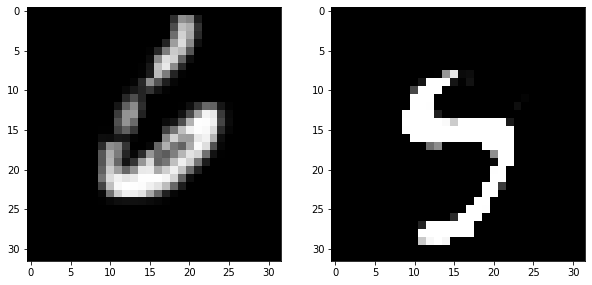

In [210]:
test(10)

In [16]:
from torchvision import datasets, transforms
all_transforms = transforms.Compose([
        transforms.Resize(32),
        transforms.ToTensor()
    ])
train_data = datasets.MNIST('/home/data/bvaa/', train=True, download=True,
                                transform=all_transforms)

In [17]:
list_index = {}
for i in range(len(train_data)):
    index = train_data[i][1]
    if index not in list_index.keys():
        list_index[index] = [i]
    else:
        list_index[index].append(i)

In [18]:
from tqdm.notebook import tqdm
l_sample_list = {}
def get_average_latent_space(list_index):
    for i in tqdm(list_index.keys()):
        for j in list_index[i]:
            output, l_dist = model(train_data[j][0].unsqueeze(0).cuda())
            l_sample_x = model.reparameterize(l_dist)
            if i not in l_sample_list.keys():
                l_sample_list[i] = [l_sample_x]
            else:
                l_sample_list[i].append(l_sample_x)
        l_sample_list[i] = torch.mean(torch.stack(l_sample_list[i]), dim=0)
        
get_average_latent_space(list_index)

In [45]:
l = []
for i in l_sample_list.keys():
    l.append(l_sample_list[i])

In [46]:
l_tensor = torch.stack(l)

In [47]:
l = l_tensor.squeeze(1)

In [48]:
l.shape

torch.Size([10, 20])

In [72]:
torch.save(l, 'tensor/latent.pt')

In [73]:
e = torch.load('tensor/latent.pt')

In [56]:
coff = torch.randn((2,10))

In [57]:
coff.shape

torch.Size([2, 10])

In [63]:
m = coff[:,None].cuda()*l.T
r = torch.transpose(m,1,2) 
r.sum(1)

In [65]:
r = torch.transpose(m,1,2)   

In [69]:
r.shape

torch.Size([2, 10, 20])

In [70]:
r.sum(1).shape

torch.Size([2, 20])